# Project 3: Part 3 Modeling

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from patsy import dmatrix
import datetime as dt
import numpy as np
import pickle
from tqdm import tqdm

%matplotlib inline

from sklearn import metrics

import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn import cross_validation

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
with open("users.pkl", 'rb') as picklefile: 
    users = pickle.load(picklefile)

In [6]:
users = users.drop('id',axis = 1)

In [7]:
from sklearn.utils import resample

In [8]:
users.US.value_counts()

1    62376
0    26532
Name: US, dtype: int64

In [9]:
users.head()

,gender_FEMALE,gender_MALE,gender_OTHER,signup_method_facebook,signup_method_google,signup_app_Moweb,signup_app_Web,signup_app_iOS,langues_en,diff_account_to_first_active,diff_account_to_first_booking,age,total_sessions,total_sessions_on_mac,total_sessions_on_windows,total_sessions_on_iphone,total_sessions_on_android,US,no_age_entered
0,1,0,0,0,0,0,1,0,1,475,-57,56.000000,0.0,0.0,0.0,0.0,0.0,1,0
1,1,0,0,1,0,0,1,0,1,764,278,42.000000,0.0,0.0,0.0,0.0,0.0,0,0
2,0,0,0,0,0,0,1,0,1,279,-208,41.000000,0.0,0.0,0.0,0.0,0.0,1,0
3,0,0,0,0,0,0,1,0,1,0,1,36.924928,0.0,0.0,0.0,0.0,0.0,1,1
4,1,0,0,0,0,0,1,0,1,0,3,46.000000,0.0,0.0,0.0,0.0,0.0,1,0


In [10]:
# Separate majority and minority classes
users_majority = users[users.US==1]
users_minority = users[users.US==0]
 
# Upsample minority class
users_minority_upsampled = resample(users_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=62376,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
users_upsampled = pd.concat([users_majority, users_minority_upsampled])
 
# Display new class counts
users_upsampled.US.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    62376
0    62376
Name: US, dtype: int64

In [11]:
y_upsampled = users_upsampled['US']
users_upsampled = users_upsampled.drop('US', axis = 1)

In [12]:
xtrain, xtest, ytrain, ytest = train_test_split(users_upsampled, y_upsampled, test_size=0.2,stratify = y_upsampled)#, random_state = 1234)

In [13]:
ytest.value_counts()

0    12476
1    12475
Name: US, dtype: int64

In [14]:
ytrain.value_counts()

1    49901
0    49900
Name: US, dtype: int64

In [15]:
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
   This function prints and plots the confusion matrix.
   Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    plt.figure(figsize = (12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 34)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)


    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True',fontsize = 18)
    plt.xlabel('Predicted')


## KNN

In [16]:
normalizer = preprocessing.Normalizer()
xtrain_norm = normalizer.fit_transform(xtrain)
xtest_norm = normalizer.fit_transform(xtest)

In [17]:
k_range = list(range(1,31))
k_auc = []
for k in tqdm(k_range):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(xtrain_norm, ytrain)
    y_score = knn.predict_proba(xtest_norm)[:,1]
    fpr, tpr,_ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    k_auc.append(roc_auc)
print(k_auc)

 17%|█▋        | 5/30 [00:23<01:56,  4.66s/it]

KeyboardInterrupt: 

In [ ]:
plt.plot(k_range, k_auc)
plt.savefig('knn_k_auc')

In [ ]:
np.argmax(np.array(k_auc))

Accuracy: 0.565
             precision    recall  f1-score   support

          0       0.56      0.60      0.58     12476
          1       0.57      0.53      0.55     12475

avg / total       0.57      0.56      0.56     24951

Confusion matrix
[[7432 5044]
 [5813 6662]]
ROC AUC: 0.592861535832


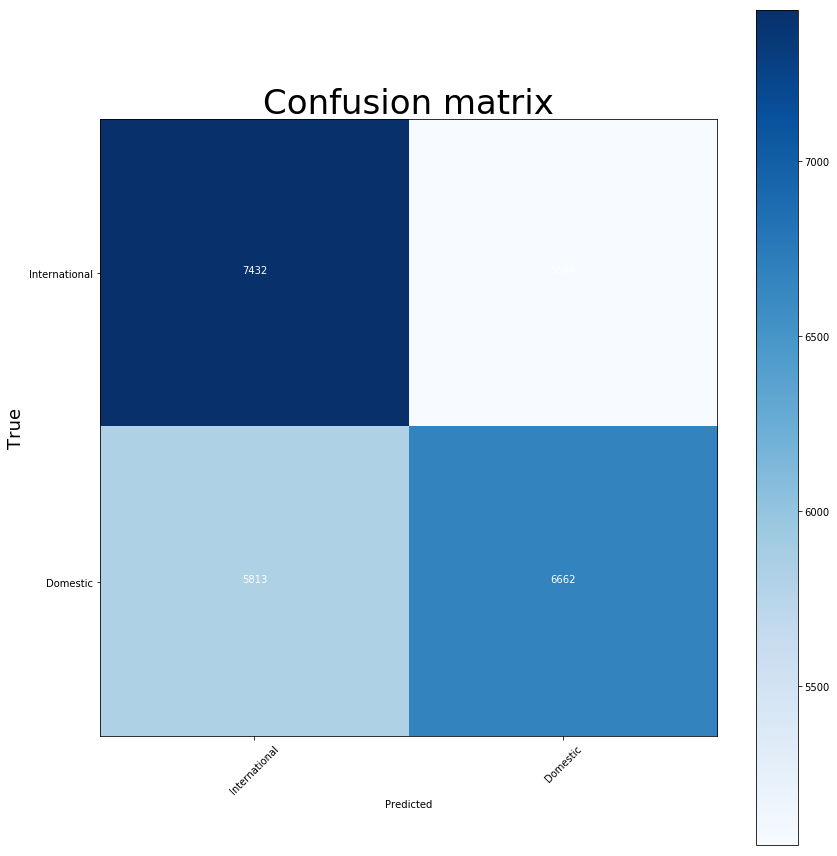

In [18]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(xtrain_norm, ytrain)
y_pred = knn.predict(xtest_norm)
y_score = knn.predict_proba(xtest_norm)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, knn.predict(xtest_norm)))
print(metrics.classification_report(ytest, knn.predict(xtest_norm)))
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])
print('ROC AUC:', roc_auc)

Accuracy: 0.592
             precision    recall  f1-score   support

          0       0.58      0.65      0.62     12476
          1       0.61      0.53      0.56     12475

avg / total       0.59      0.59      0.59     24951

Confusion matrix
[[8162 4314]
 [5867 6608]]
ROC AUC: 0.633664436921


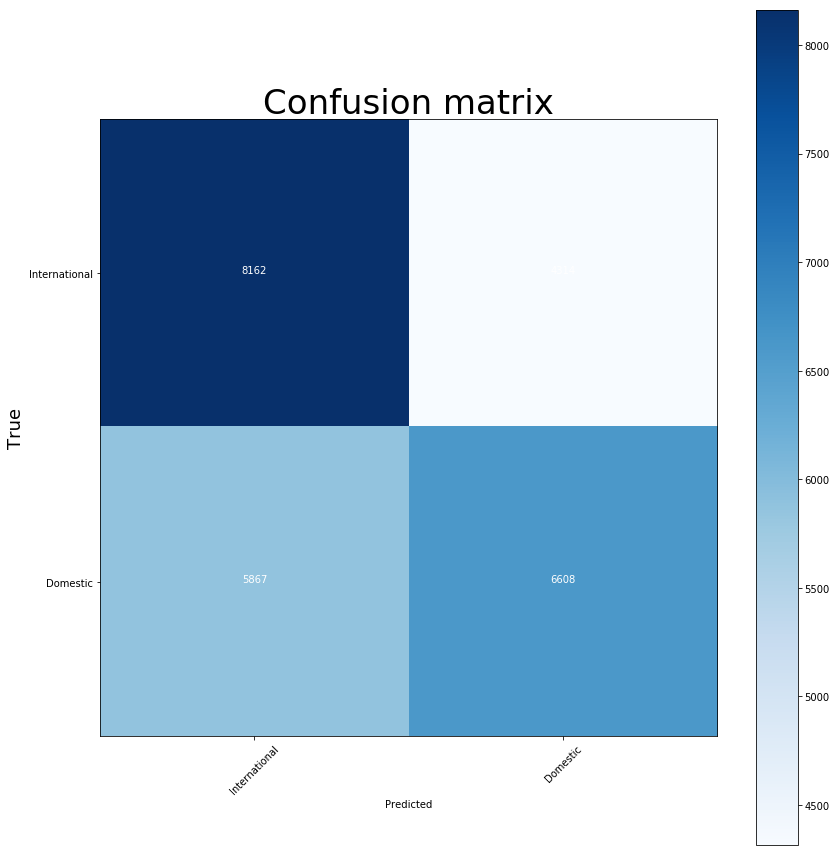

In [19]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(xtrain_norm, ytrain)
y_pred = knn5.predict(xtest_norm)
y_score = knn5.predict_proba(xtest_norm)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, knn5.predict(xtest_norm)))
print(metrics.classification_report(ytest, knn5.predict(xtest_norm)))
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])
print('ROC AUC:', roc_auc)

## SVMs

### Linear

In [29]:
l_svm = SVC(kernel='linear')
l_svm.fit(xtrain_norm, ytrain_norm)
y_pred = l_svm.predict(xtest_norm)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest_norm, l_svm.predict(xtest_norm)))
print(metrics.classification_report(ytest_norm, l_svm.predict(xtest_norm)))
print(metrics.confusion_matrix(ytest_norm,l_svm.predict(xtest_norm)))

Accuracy: 0.702


/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00      5307
          1       0.70      1.00      0.82     12475

avg / total       0.49      0.70      0.58     17782

[[    0  5307]
 [    0 12475]]


### RBF

In [ ]:
rbf_svm = SVC(kernel='rbf', gamma = 0.001)
rbf_svm.fit(xtrain_norm, ytrain_norm)
y_pred = svm.predict(xtest_norm)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest_norm, rbf_svm.predict(xtest_norm)))
print(metrics.classification_report(ytest_norm, rbf_svm.predict(xtest_norm)))
print(metrics.confusion_matrix(ytest_norm,rbf_svm.predict(xtest_norm)))

## Logistic Regression

Accuracy: 0.520
             precision    recall  f1-score   support

          0       0.52      0.50      0.51     12476
          1       0.52      0.54      0.53     12475

avg / total       0.52      0.52      0.52     24951

Confusion matrix
[[6188 6288]
 [5678 6797]]
ROC AUC: 0.532438159422


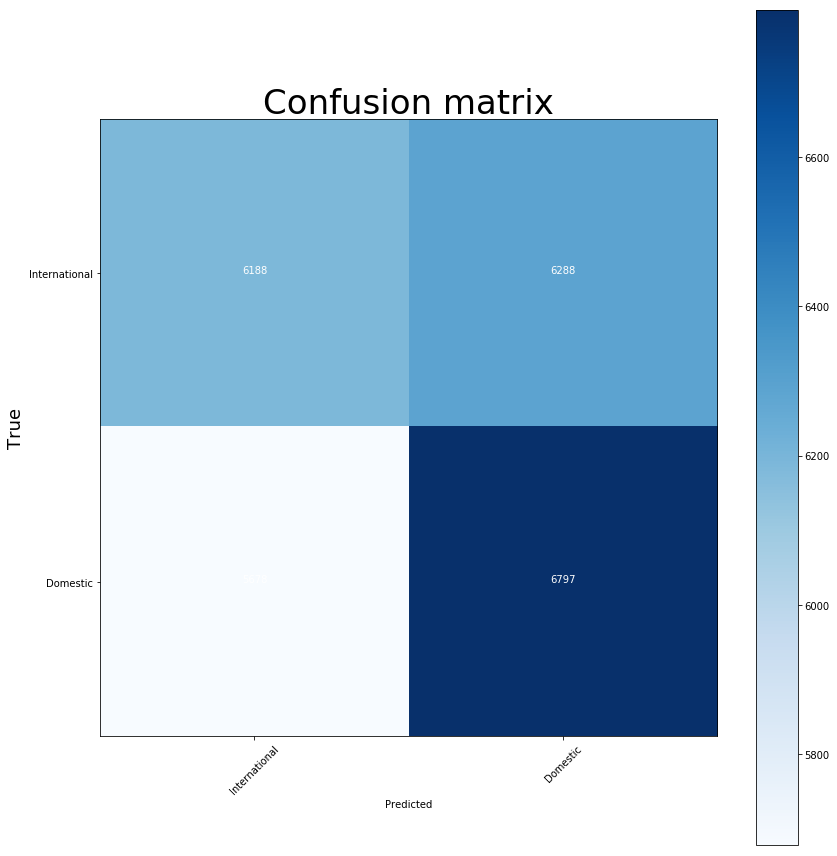

In [20]:
lr = LogisticRegression(class_weight = 'balanced')
lr.fit(xtrain, ytrain)
y_pred = lr.predict(xtest)
y_score = lr.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)
    

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, lr.predict(xtest)))
print(metrics.classification_report(ytest, lr.predict(xtest)))
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])
print('ROC AUC:', roc_auc)

100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


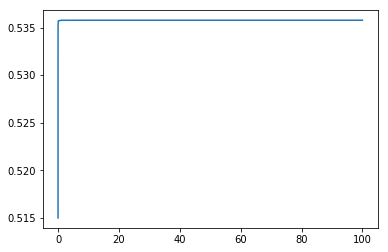

In [96]:
c_range = [0.00001,0.001, 0.01, 0.1, 1, 10,100]
c_auc = []

for c in tqdm(c_range):

    lr = LogisticRegression(class_weight = 'balanced', C = c)
    lr.fit(xtrain, ytrain)
    y_pred = lr.predict(xtest)
    y_score = lr.predict_proba(xtest)[:,1]
    fpr, tpr,_ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    c_auc.append(roc_auc)
    

plt.plot(c_range, c_auc)
plt.savefig('c_auc')

In [97]:
np.argmax(np.array(c_auc))

6

Accuracy: 0.520
             precision    recall  f1-score   support

          0       0.52      0.50      0.51     12476
          1       0.52      0.54      0.53     12475

avg / total       0.52      0.52      0.52     24951

Confusion matrix
[[6199 6277]
 [5689 6786]]
ROC AUC: 0.532461463485


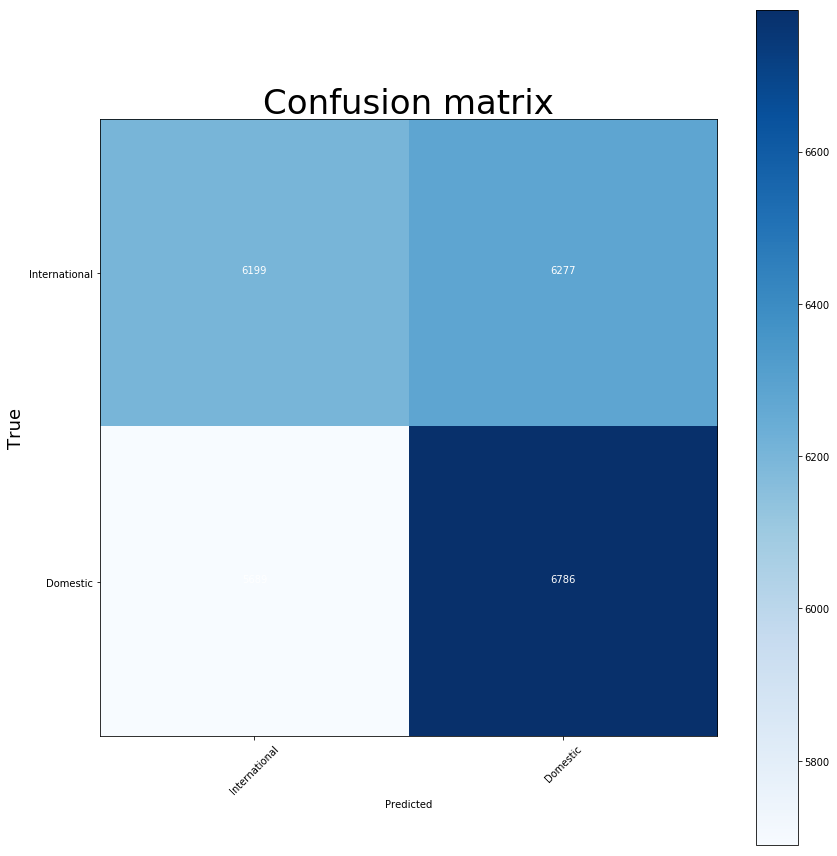

In [21]:
lr = LogisticRegression(class_weight = 'balanced', C = 100)
lr.fit(xtrain, ytrain)
y_pred = lr.predict(xtest)
y_score = lr.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)
    

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, lr.predict(xtest)))
print(metrics.classification_report(ytest, lr.predict(xtest)))
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])
print('ROC AUC:', roc_auc)

## Random Forests

Accuracy: 0.641
             precision    recall  f1-score   support

          0       0.64      0.65      0.65     12476
          1       0.64      0.63      0.64     12475

avg / total       0.64      0.64      0.64     24951

ROC AUC: 0.714183490418
Confusion matrix
[[8140 4336]
 [4610 7865]]


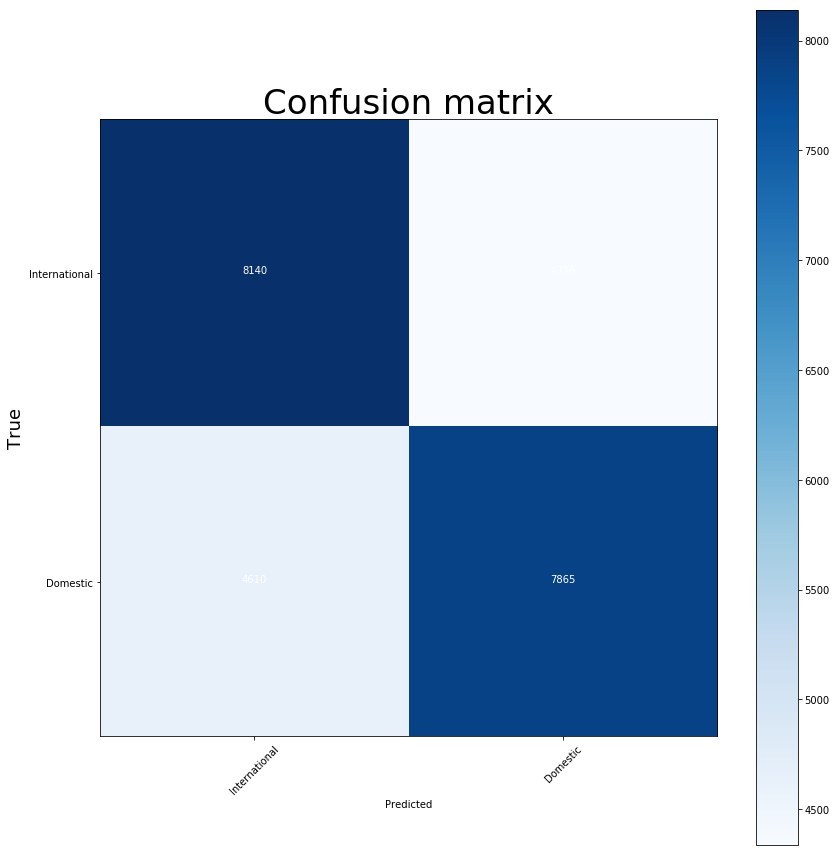

In [22]:
rf = RandomForestClassifier(max_depth = 20,n_estimators = 40)# class_weight = 'balanced')
rf.fit(xtrain, ytrain)
y_pred = rf.predict(xtest)
y_score = rf.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, rf.predict(xtest)))
print(metrics.classification_report(ytest, rf.predict(xtest)))
print('ROC AUC:', roc_auc)
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])

In [27]:
n_range = list(range(10,100))
n_up_auc = []
for n in tqdm(n_range):
    rf = RandomForestClassifier(n_estimators = n)#class_weight = 'balanced')
    rf.fit(xtrain, ytrain)
    y_score = rf.predict_proba(xtest)[:,1]
    fpr, tpr,_ = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    n_up_auc.append(roc_auc)
print(n_up_auc)

100%|██████████| 90/90 [08:18<00:00,  5.54s/it]

[0.76317588366858757, 0.76549208066662344, 0.76640188360048089, 0.76592897240457192, 0.76724750237891626, 0.7684333045700249, 0.76673576714185021, 0.76887143957681314, 0.77042994292528633, 0.77221053199698519, 0.77210590465959161, 0.77055101867730336, 0.77112402104626043, 0.77248027635906635, 0.77098366338319479, 0.77281140993111574, 0.77161909262577733, 0.77263717560160394, 0.77185789662042903, 0.77299572855232745, 0.77285503999342064, 0.77251774469104939, 0.77443493591864709, 0.77470251821372782, 0.77474616755151859, 0.77383926557828708, 0.77476767899376831, 0.77434842753798716, 0.77448936025304849, 0.77434691441234516, 0.7749943747707021, 0.7745217912580532, 0.77336502437385202, 0.77462965366449477, 0.77477846684070295, 0.77431713057406903, 0.77618918503888201, 0.77524663947966455, 0.77538532981320119, 0.77520003777995239, 0.77440574962043363, 0.77598961629575292, 0.77520291625251136, 0.77498464065032935, 0.77546211049865044, 0.77593479681389066, 0.77594155287169408, 0.7754854049233

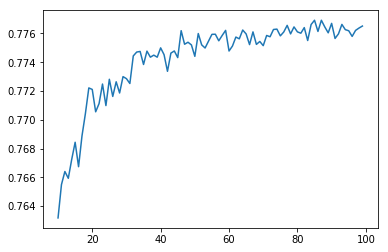

In [28]:
plt.plot(n_range, n_up_auc)
plt.savefig('n_up_auc')

In [29]:
np.argmax(np.array(n_up_auc))

75

Accuracy: 0.677
             precision    recall  f1-score   support

          0       0.67      0.71      0.69     12476
          1       0.69      0.65      0.67     12475

avg / total       0.68      0.68      0.68     24951

ROC AUC: 0.759275466611
Confusion matrix
[[8803 3673]
 [4396 8079]]


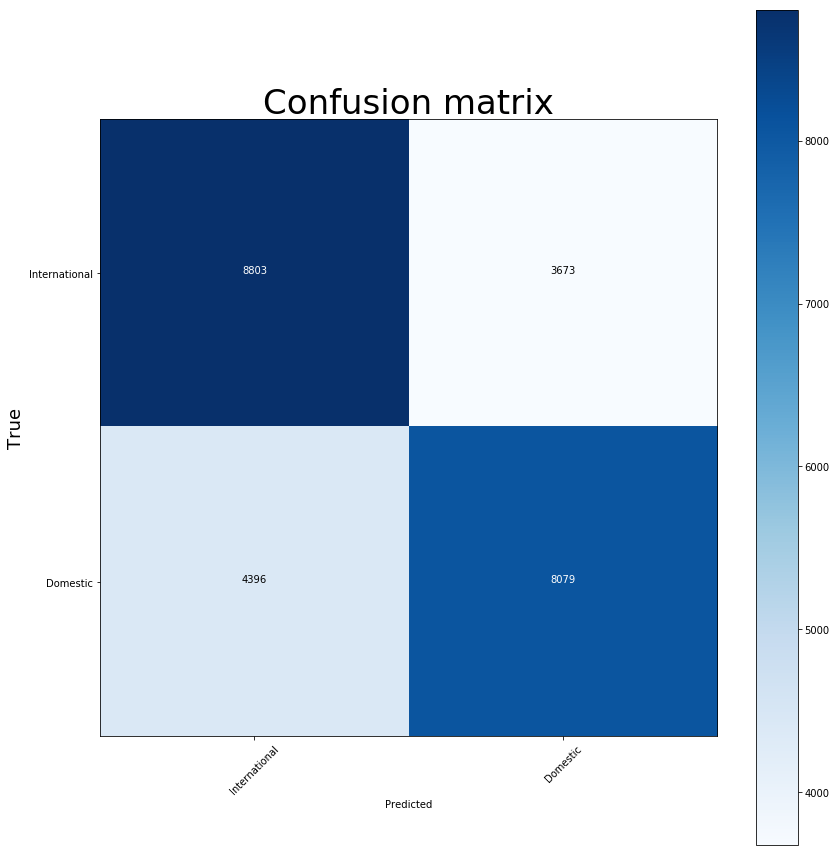

In [23]:
rf_64 = RandomForestClassifier(max_depth = 25,n_estimators = 75,class_weight = 'balanced', random_state = 123)
rf_64.fit(xtrain, ytrain)
y_pred = rf_64.predict(xtest)
y_score = rf_64.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, rf_64.predict(xtest)))
print(metrics.classification_report(ytest, rf_64.predict(xtest)))
print('ROC AUC:', roc_auc)
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['International', 'Domestic'])
plt.savefig('rf_75_confusion_matrix',bbox_inches='tight')

In [ ]:
features = pd.DataFrame()
features['importances'] = rf_64.feature_importances_
features['features'] = xtrain.columns
features.sort_values('importances',ascending = False)

In [180]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(xtrain_up.columns)
dot_data = StringIO()  
export_graphviz(rf_64, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

## XGBoost

In [28]:
params = {"objective": "multi:softmax", "num_class": 30}

T_train_xgb = xgb.DMatrix(xtrain, ytrain)
X_test_xgb  = xgb.DMatrix(xtest)

gbm = xgb.train(params, T_train_xgb, 40)
y_pred = gbm.predict(X_test_xgb)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, y_pred))
print(metrics.classification_report(ytest, y_pred))
print(metrics.confusion_matrix(ytest,y_pred))

Accuracy: 0.565
             precision    recall  f1-score   support

          0       0.57      0.53      0.55     12476
          1       0.56      0.59      0.58     12475

avg / total       0.56      0.56      0.56     24951

[[6674 5802]
 [5060 7415]]


## Naive Bayes

### Gaussian

Accuracy: 0.513
             precision    recall  f1-score   support

          0       0.51      0.92      0.65     12476
          1       0.57      0.10      0.18     12475

avg / total       0.54      0.51      0.42     24951

ROC AUC: 0.528878992355
Confusion matrix
[[11504   972]
 [11177  1298]]


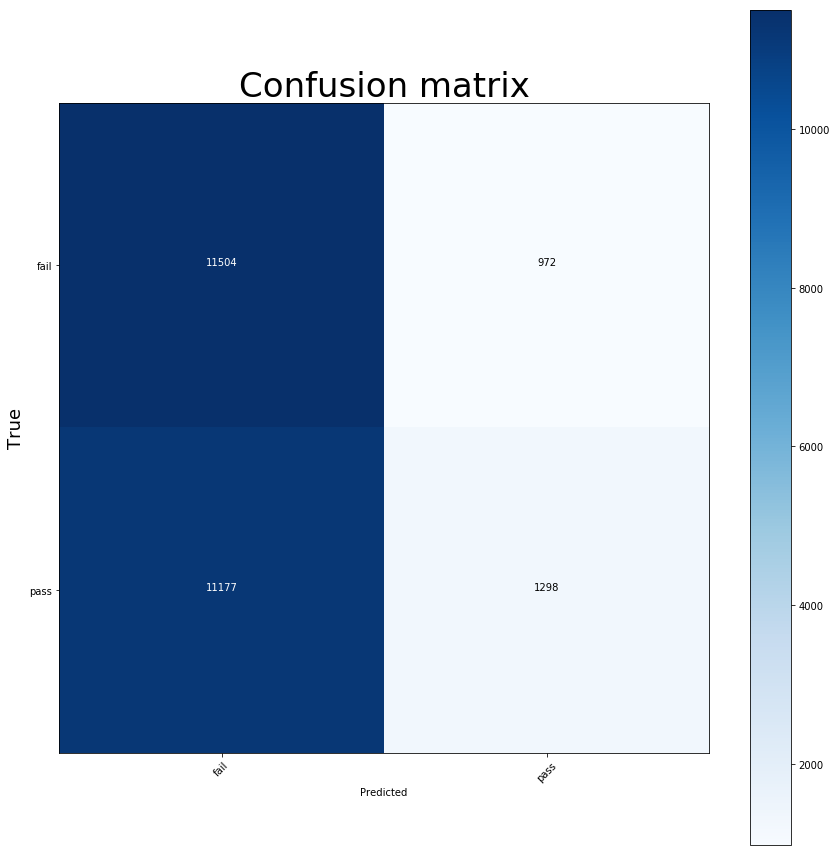

In [24]:
nb_g = naive_bayes.GaussianNB()
nb_g.fit(xtrain, ytrain)
y_pred = nb_g.predict(xtest)
y_score = nb_g.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest,y_pred ))
print(metrics.classification_report(ytest, nb_g.predict(xtest)))
print('ROC AUC:', roc_auc)
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['fail', 'pass'])

### Bernoulli

Accuracy: 0.527
             precision    recall  f1-score   support

          0       0.52      0.70      0.60     12476
          1       0.54      0.36      0.43     12475

avg / total       0.53      0.53      0.51     24951

ROC AUC: 0.544844254074
Confusion matrix
[[8680 3796]
 [8002 4473]]


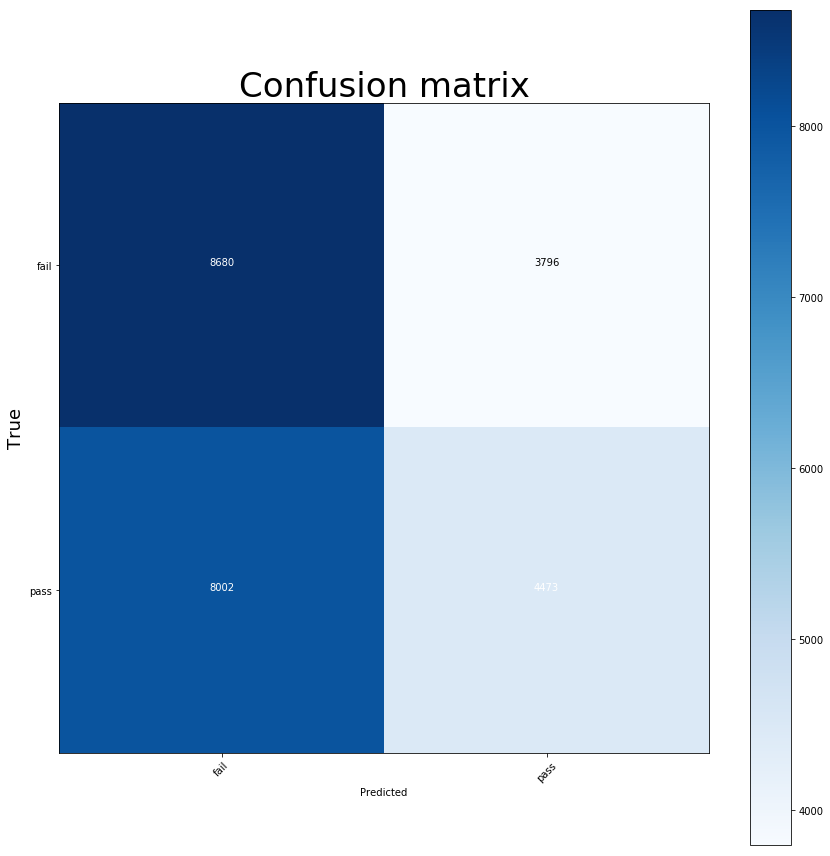

In [25]:
nb_b = naive_bayes.BernoulliNB()
nb_b.fit(xtrain, ytrain)
y_pred = nb_b.predict(xtest)
y_score = nb_b.predict_proba(xtest)[:,1]
fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

print("Accuracy: %.3f"% metrics.accuracy_score(ytest, y_pred))
print(metrics.classification_report(ytest, nb_b.predict(xtest)))
print('ROC AUC:', roc_auc)
plot_confusion_matrix(confusion_matrix(ytest,y_pred), ['fail', 'pass'])

## Roc Curves

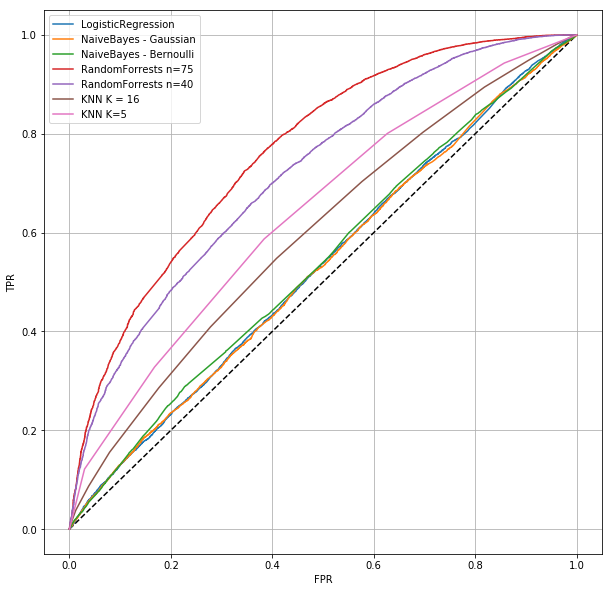

In [27]:
# What about ROC ? 




lr_score=lr.predict_proba(xtest)[:,1]
nb_g_score = nb_g.predict_proba(xtest)[:,1]
nb_b_score = nb_b.predict_proba(xtest)[:,1]
rf_64_score = rf_64.predict_proba(xtest)[:,1]
rf_score = rf.predict_proba(xtest)[:,1]
knn_score = knn.predict_proba(xtest_norm)[:,1]
knn5_score = knn5.predict_proba(xtest_norm)[:,1]
#l_svm_score = l_svm.predict_proba(xtest)[:,1]

lr_fpr, lr_tpr,_ = roc_curve(ytest, lr_score)
nb_g_fpr, nb_g_tpr,_ = roc_curve(ytest, nb_g_score)
nb_b_fpr, nb_b_tpr,_ = roc_curve(ytest, nb_b_score)
rf_64_fpr, rf_64_tpr,_ = roc_curve(ytest, rf_64_score)
rf_fpr, rf_tpr,_ = roc_curve(ytest, rf_score)
knn_fpr, knn_tpr,_ = roc_curve(ytest, knn_score)
knn5_fpr, knn5_tpr,_ = roc_curve(ytest, knn5_score)
#l_svm_fpr, l_svm_tpr,_ = roc_curve(ytest, l_svm_score)
#roc_auc = auc(fpr, tpr)

plt.figure(figsize = (10,10))
plt.subplot(1,1,1)
# Plotting our Baseline..
plt.plot([0,1],[0,1], 'k--')

plt.plot(lr_fpr,lr_tpr, label = 'LogisticRegression')
plt.plot(nb_g_fpr,nb_g_tpr, label = 'NaiveBayes - Gaussian')
plt.plot(nb_b_fpr,nb_b_tpr, label = 'NaiveBayes - Bernoulli')
plt.plot(rf_64_fpr,rf_64_tpr, label = 'RandomForrests n=75')
plt.plot(rf_fpr,rf_tpr, label = 'RandomForrests n=40')
plt.plot(knn_fpr,knn_tpr, label = 'KNN K = 16')
plt.plot(knn5_fpr,knn5_tpr, label = 'KNN K=5')
#plt.plot(l_svm_fpr,l_svm_tpr, label = 'SVM-Linear')

plt.legend()
plt.grid(True)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.savefig('RocCurve')

## Final Model

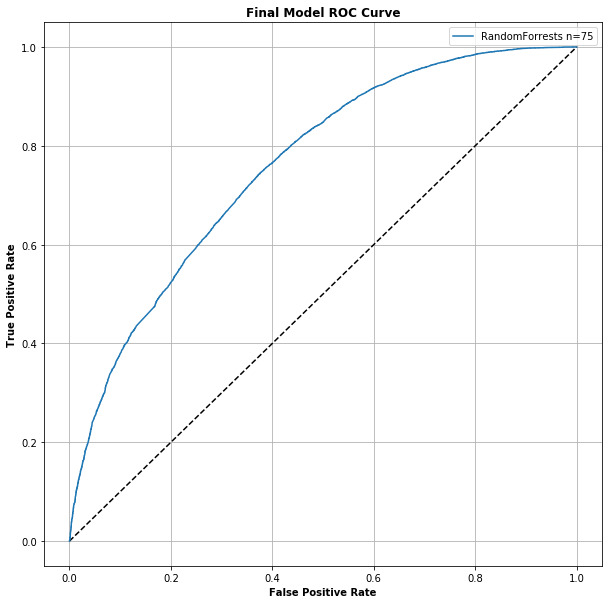

In [31]:
rf_64_score = rf_64.predict_proba(xtest)[:,1]
rf_64_fpr, rf_64_tpr,_ = roc_curve(ytest, rf_64_score)
plt.figure(figsize = (10,10))
plt.subplot(1,1,1)
# Plotting our Baseline..
plt.plot([0,1],[0,1], 'k--')
plt.plot(rf_64_fpr,rf_64_tpr, label = 'RandomForrests n=75')
plt.legend()
plt.grid(True)
plt.xlabel('False Positive Rate', fontweight = 'bold')
plt.ylabel('True Positive Rate', fontweight = 'bold')
plt.title('Final Model ROC Curve', fontweight = 'bold')

plt.savefig('FinalRFRocCurve')

In [36]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/emilygeller/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


<module 'matplotlib.pyplot' from '/Users/emilygeller/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

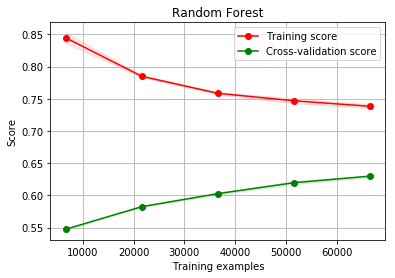

In [37]:
plot_learning_curve(model, 'Random Forest', xtrain, ytrain,)

### Prep for use in app

In [34]:
model = RandomForestClassifier(max_depth = 20,n_estimators = 75,class_weight = 'balanced', random_state = 123)
model.fit(xtrain, ytrain)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=75, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False)

In [23]:
airbnb_dict = ('airbnb_model': model, 'airbnb_features': list(xtrain.columns),

['gender_FEMALE',
 'gender_MALE',
 'gender_OTHER',
 'signup_method_facebook',
 'signup_method_google',
 'signup_app_Moweb',
 'signup_app_Web',
 'signup_app_iOS',
 'langues_en',
 'diff_account_to_first_active',
 'diff_account_to_first_booking',
 'age',
 'total_sessions',
 'total_sessions_on_mac',
 'total_sessions_on_windows',
 'total_sessions_on_iphone',
 'total_sessions_on_android',
 'no_age_entered']

In [144]:
pickle.dump(model, open("airbnb_firstdestinations_model.p", "wb"))

In [130]:
#model = pickle.load( open( "airbnb_firstdestinations_model.p", "rb" ), encoding='latin1' )

def airbnb_firstdestination(gender, 
                            signup_method, 
                            signup_app, 
                            langues_en, 
                            diff_account_to_first_active, 
                            diff_account_to_first_booking, 
                            age, 
                            total_sessions_on_mac, 
                            total_sessions_on_windows, 
                            total_sessions_on_iphone, 
                            total_sessions_on_android):
    # categorical features:
    gender_inputs = {'male': [0,1,0], 'female': [1,0,0], 'other': [0,0,1], 'unknown': [0,0,0]}
    signup_method_inputs = {'facebook': [1,0], 'google': [0,1], 'direct': [0,0]}
    signup_app_inputs = {'moweb': [1,0,0], 'web': [0,1,0], 'ios':[0,0,1], 'android':[0,0,0]}
    language_en_inputs = {'true': [1], 'false': [0]}
    
    # numerical features
    total_sessions_on_mac = int(total_sessions_on_mac)
    total_sessions_on_windows = int(total_sessions_on_windows)
    total_sessions_on_iphone = int(total_sessions_on_iphone)
    total_sessions_on_android = int(total_sessions_on_android)
    diff_account_to_first_active = int(diff_account_to_first_active)
    diff_account_to_first_booking = int(diff_account_to_first_booking)
    
    total_sessions_input = total_sessions_on_mac + total_sessions_on_windows + total_sessions_on_iphone + total_sessions_on_android
    if age == '':
        no_age_entered = 1
        age = 37 # mean age
    else:
        no_age_entered = 0
        age = int(age)

        
    inputs = []
    inputs.extend(gender_inputs[gender])
    inputs.extend(signup_method_inputs[signup_method])
    inputs.extend(signup_app_inputs[signup_app])
    inputs.extend(language_en_inputs[langues_en])
    inputs.append(diff_account_to_first_active)
    inputs.append(diff_account_to_first_booking)
    inputs.append(age)
    inputs.append(total_sessions_input)
    inputs.append(total_sessions_on_mac)
    inputs.append(total_sessions_on_windows)
    inputs.append(total_sessions_on_iphone)
    inputs.append(total_sessions_on_android)
    inputs.append(no_age_entered)
    
    return model.predict_proba([inputs]), model.predict([inputs])

In [143]:
airbnb_firstdestination('male', 
                            'facebook', 
                            'web', 
                            'true', #language
                            0, # diff_account_to_first_active,
                            200, # diff_account_to_first_booking,
                            40, # age, 
                            1, # mac
                            100, # windows
                            1, # iphone
                            100) # android

(array([[ 0.36307697,  0.63692303]]), array([1], dtype=uint8))

In [86]:
model.classes_

array([0, 1], dtype=uint8)

In [37]:
inputs = []
gender_inputs = {'male': [0,1,0], 'female': [1,0,0], 'other': [0,0,1], 'unknown': [0,0,0]}
inputs.extend(gender_inputs['male'])
inputs

[0, 1, 0]

In [79]:
age = '23'
int(age)

23

In [28]:
model.predict_proba(xtest)

array([[ 0.68      ,  0.32      ],
       [ 0.20341135,  0.79658865],
       [ 0.25904768,  0.74095232],
       ..., 
       [ 0.50582563,  0.49417437],
       [ 0.36735639,  0.63264361],
       [ 0.68055377,  0.31944623]])

In [82]:
users.age.describe()

count    88908.000000
mean        36.924928
std         12.272861
min          0.000000
25%         30.000000
50%         36.924928
75%         38.000000
max        115.000000
Name: age, dtype: float64